In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import tensorflow.keras as keras
tf.__version__

'2.18.0'

In [ ]:
import os
import zipfile

local_zip = '/tmp/image_scene.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/image_scene')
zip_ref.close()

In [ ]:
base_dir = '/tmp/image_scene'

#train directories
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')

In [ ]:
import shutil

# create directories for partial train and test data (200 images/category)

categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
num_images = 350
partial_train_dir = '/tmp/partial_train'
partial_test_dir = '/tmp/partial_test'

os.makedirs(partial_train_dir, exist_ok=True)
os.makedirs(partial_test_dir, exist_ok=True)

In [ ]:
# copy 200 images from each category to 'partial...' directives
def reduce_data(input_dir, output_dir):
  for category in categories:
    category_dir = os.path.join(input_dir, category)
    output_category_dir = os.path.join(output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    image_files = os.listdir(category_dir)[:num_images]
    for image_file in image_files:
      source_path = os.path.join(category_dir, image_file)
      dst_path = os.path.join(output_category_dir, image_file)
      shutil.copy(source_path, dst_path)

reduce_data(train_dir, partial_train_dir)
reduce_data(test_dir, partial_test_dir)

In [ ]:
# initilaizing training arrays
train_images = []
train_labels = []

In [ ]:
import numpy as np

# only for training data
# combine all subpaths to one
# so that later we can use flow_from_dataframe
def combining_paths(input_dir, features_array, labels_array):
  for category in categories:
    category_dir = os.path.join(input_dir, category)
    for fname in os.listdir(category_dir):
      features_array.append(os.path.join(category_dir, fname))
      labels_array.append(category)

combining_paths(partial_train_dir, train_images, train_labels)

# will use flow from directory for test data

In [ ]:
# convert all training arrays to numpy arrays (dataframe) of images
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.regularizers import l2

#baseline network

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,784,198 (18.25 MB)

 Trainable params: 4,784,198 (18.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#data augmentation

# no augmenting
train_augment = ImageDataGenerator(rescale=1./255)

# do not augment val and test data!
val_augment = ImageDataGenerator(rescale=1./255)
test_augment = ImageDataGenerator(rescale=1./255)

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from sklearn.model_selection import KFold
import pandas as pd

k=4
kf = KFold(n_splits=k, shuffle=True, random_state=42)
all_scores=[]
num_epochs = 30
batch_size = 35

train_acc = []
val_acc =  []
train_loss = []
val_loss = []

In [ ]:
test_generator = test_augment.flow_from_directory(
    partial_test_dir,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2081 images belonging to 6 classes.


In [ ]:
history = None #manually resets history everytime when running cell

for fold, (train_idx, val_idx) in enumerate(kf.split(train_images)):
  print(f'\nProcessing fold # {fold+1}/{k}###########################')

  #split train_images dataframe into train and val
  train_x, val_x = train_images[train_idx], train_images[val_idx]
  train_y, val_y = train_labels[train_idx], train_labels[val_idx]

  # train generator use flow from dataframe
  train_generator = train_augment.flow_from_dataframe(
    dataframe = pd.DataFrame({'filename': train_x, 'class': train_y}),
    x_col = 'filename',
    y_col = 'class',
    target_size = (150,150),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=True)

  # val generator use flow from dataframe
  val_generator = val_augment.flow_from_dataframe(
      dataframe = pd.DataFrame({'filename': val_x, 'class': val_y}),
      x_col = 'filename',
      y_col = 'class',
      target_size = (150,150),
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle = True
  )

  history = model.fit(
      train_generator,
      steps_per_epoch = 80, #2100 images = batch size(25) * steps (60)
      epochs=num_epochs,
      validation_data=val_generator,
      validation_steps = 80)

  train_acc.append(history.history['acc'])
  val_acc.append(history.history['val_acc'])
  train_loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



Processing fold # 1/4###########################
Found 1575 validated image filenames belonging to 6 classes.
Found 525 validated image filenames belonging to 6 classes.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/80 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.2163 - loss: 6.6847

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - acc: 0.2370 - loss: 6.5585 - val_acc: 0.3867 - val_loss: 5.7444
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.4189 - loss: 5.5140 - val_acc: 0.4781 - val_loss: 5.1038
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.4834 - loss: 4.8142 - val_acc: 0.4933 - val_loss: 4.4719
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.4835 - loss: 4.3363 - val_acc: 0.4800 - val_loss: 4.0921
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.5251 - loss: 3.8486 - val_acc: 0.5657 - val_loss: 3.6360
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.5746 - loss: 3.4670 - val_acc: 0.5314 - val_loss: 3.4590
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.5525 - loss: 3.2396 - val_acc: 0.5905 - val_loss: 3.0186
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - acc: 0.6040 - loss: 2.8947 - val_acc: 0.5600 - val_loss: 2.8106
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.6198 - loss: 2

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/80 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.7935 - loss: 1.0958

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - acc: 0.7950 - loss: 1.0942 - val_acc: 0.8705 - val_loss: 0.8946
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.8416 - loss: 0.9377 - val_acc: 0.8857 - val_loss: 0.8054
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - acc: 0.8676 - loss: 0.8796 - val_acc: 0.8724 - val_loss: 0.8337
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.8815 - loss: 0.8338 - val_acc: 0.8667 - val_loss: 0.8245
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.8754 - loss: 0.8001 - val_acc: 0.8343 - val_loss: 0.8885
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.8802 - loss: 0.7853 - val_acc: 0.8210 - val_loss: 0.9021
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - acc: 0.8816 - loss: 0.7487 - val_acc: 0.8171 - val_loss: 0.9000
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - acc: 0.8948 - loss: 0.7151 - val_acc: 0.8495 - val_loss: 0.8030
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9017 - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/80 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.8740 - loss: 0.6413

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - acc: 0.8666 - loss: 0.6502 - val_acc: 0.9543 - val_loss: 0.4093
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.9330 - loss: 0.4579 - val_acc: 0.9638 - val_loss: 0.3604
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9392 - loss: 0.4066 - val_acc: 0.9829 - val_loss: 0.3096
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - acc: 0.9605 - loss: 0.3430 - val_acc: 0.9867 - val_loss: 0.3031
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9773 - loss: 0.3039 - val_acc: 0.9771 - val_loss: 0.2963
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9730 - loss: 0.3043 - val_acc: 0.9352 - val_loss: 0.3985
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.9512 - loss: 0.3450 - val_acc: 0.9752 - val_loss: 0.2949
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9868 - loss: 0.2709 - val_acc: 0.9829 - val_loss: 0.2652
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.9945 - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/80 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9273 - loss: 0.3324

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - acc: 0.9320 - loss: 0.3173 - val_acc: 0.9829 - val_loss: 0.1755
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9813 - loss: 0.1941 - val_acc: 0.9943 - val_loss: 0.1480
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9953 - loss: 0.1380 - val_acc: 0.9943 - val_loss: 0.1282
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - acc: 0.9960 - loss: 0.1291 - val_acc: 0.9962 - val_loss: 0.1279
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.9959 - loss: 0.1247 - val_acc: 0.9867 - val_loss: 0.1435
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9867 - loss: 0.1450 - val_acc: 0.9886 - val_loss: 0.1414
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.9896 - loss: 0.1469 - val_acc: 0.9771 - val_loss: 0.1692
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9904 - loss: 0.1326 - val_acc: 0.9886 - val_loss: 0.1294
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.9898 - loss: 0.

In [ ]:
model.save('image_scene_complex.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - acc: 0.7304 - loss: 1.8358


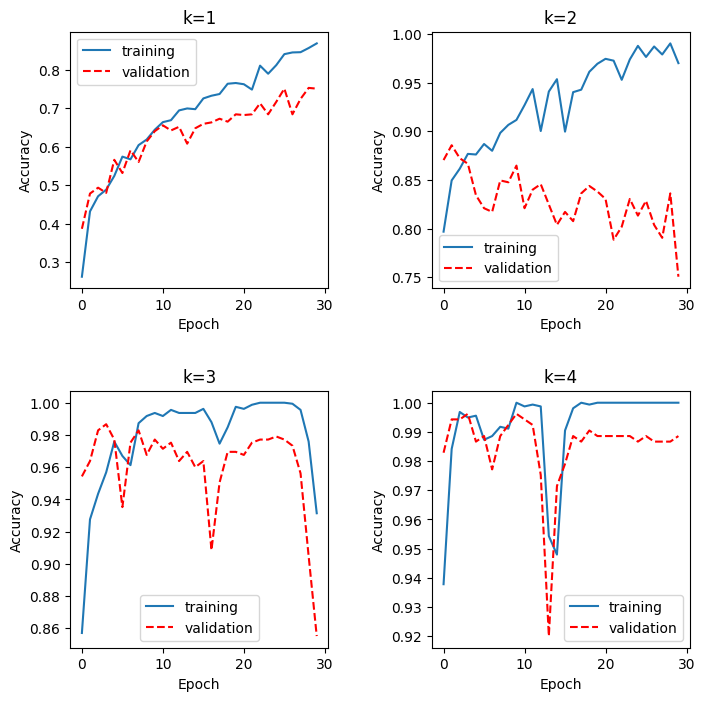

In [ ]:
import matplotlib.pyplot as plt

# Cross fold 0
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0, 0].plot(np.arange(num_epochs), train_acc[0], label='training')
axs[0, 0].plot(np.arange(num_epochs), val_acc[0], 'r--', label='validation')
axs[0, 0].set_title("k=1")
axs[0, 0].set(xlabel='Epoch', ylabel='Accuracy')
axs[0, 0].legend()

# Cross fold 1
axs[0, 1].plot(np.arange(num_epochs), train_acc[1], label='training')
axs[0, 1].plot(np.arange(num_epochs), val_acc[1], 'r--', label='validation')
axs[0, 1].set_title("k=2")
axs[0, 1].set(xlabel='Epoch', ylabel='Accuracy')
axs[0, 1].legend()

# Cross fold 2
axs[1, 0].plot(np.arange(num_epochs), train_acc[2], label='training')
axs[1, 0].plot(np.arange(num_epochs), val_acc[2], 'r--', label='validation')
axs[1, 0].set_title("k=3")
axs[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
axs[1, 0].legend()

# Cross fold 3
axs[1, 1].plot(np.arange(num_epochs), train_acc[3], label='training')
axs[1, 1].plot(np.arange(num_epochs), val_acc[3], 'r--', label='validation')
axs[1, 1].set_title("k=4")
axs[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
axs[1, 1].legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


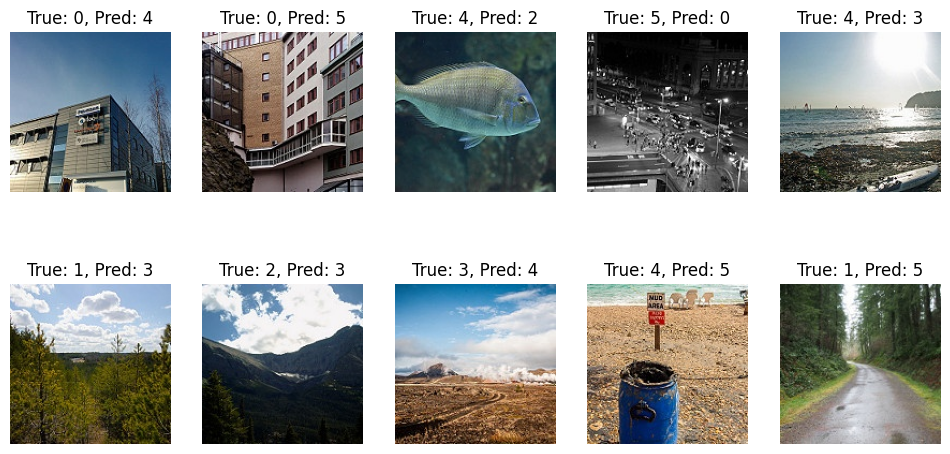

In [ ]:
# Get predictions on validation set
test_images, test_labels = next(test_generator)  # Get a batch
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Identify misclassified samples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Display a few misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[:10]):
    axes[i // 5, i % 5].imshow(test_images[idx])
    axes[i // 5, i % 5].set_title(f'True: {true_classes[idx]}, Pred: {predicted_classes[idx]}')
    axes[i // 5, i % 5].axis('off')

plt.show()